# BlueSky Above: Pollution estimation using hyper-spectral satellite imagery and maps

## Purpose
The notebook has the necessary routines/codes for downloading the maps and the hyper-spectral satellite data.

 Author: William Navaraj, 2021, released CC3.0 BY-NC-SA

# Setup

## Libraries/packages
We install all the required Python pip libraries

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install smopy
!{sys.executable} -m pip install sentinelsat


## Downloading the map
We download the map using the smopy package either with labels or without labels. You are free to access and use any other features of the openstreetmaps.

Lowered zoom level to keep map size reasonable. (z = 10)


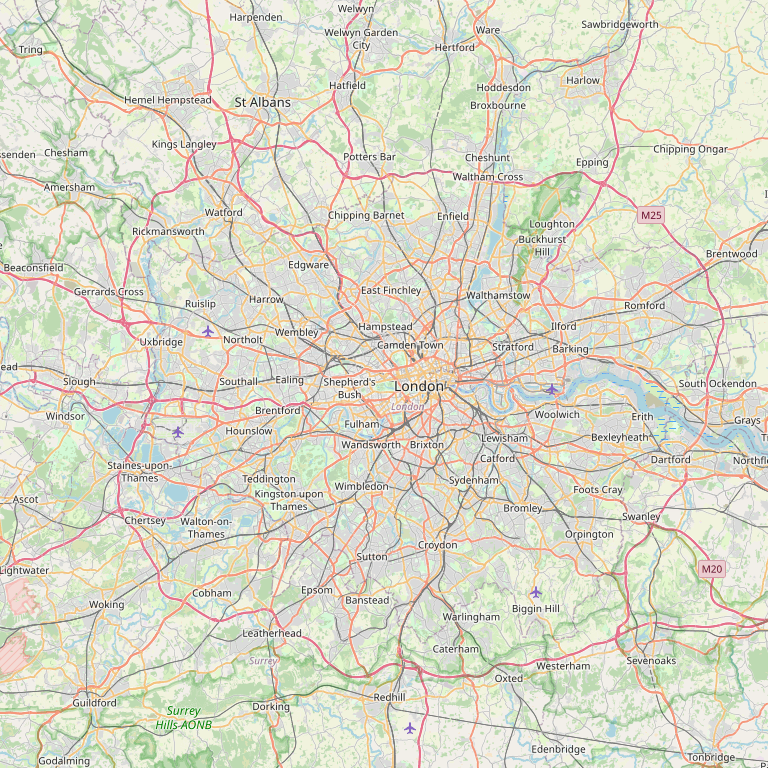

Lowered zoom level to keep map size reasonable. (z = 10)


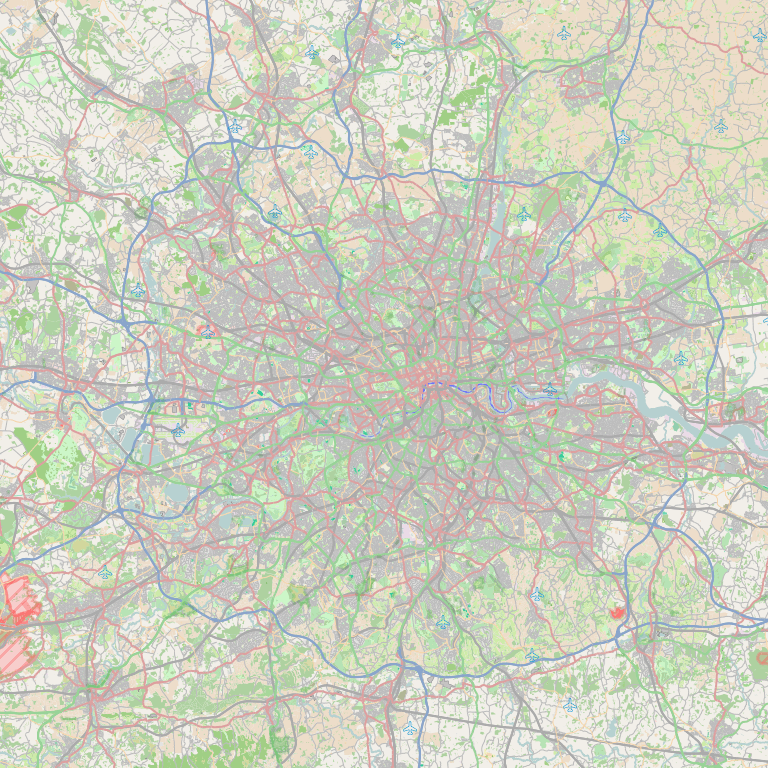

In [2]:

import smopy
#WMF Maps terms of use https://foundation.wikimedia.org/wiki/Maps_Terms_of_Use
#OSM tile server terms of use/Tile usage policy https://operations.osmfoundation.org/policies/tiles/

LatMin=51.25
LatMax=51.75
LngMin=-0.6
LngMax=0.28

#Map with labels
map = smopy.Map((LatMin,LngMin, LatMax,LngMax))
map.save_png('London.png')
map.show_ipython()

#Map without labels (if needed)
map = smopy.Map((LatMin,LngMin, LatMax,LngMax), tileserver="https://tiles.wmflabs.org/osm-no-labels/{z}/{x}/{y}.png")#,tilesize=512,maxtiles=9)
map.save_png('London2.png')
map.show_ipython()

#A matplotlib figure can be created from these images which could be used for further processing. Further downsizing or cropping or overlays can be done as per your need.
# The Map object comes with a to_pixels method to convert from geographical coordinates to pixels in this image.
#https://github.com/rossant/smopy

#x, y = map.to_pixels(51.5072, -0.1276)
#ax = map.show_mpl(figsize=(8, 8))
#ax.plot(x, y, 'or', ms=10, mew=2)



## Downloading the hyperspectral satellite data
We download the hyperspectral sentinel 5P satellite data from the copernicus datahub. This may download upto 9.4 GB of netCDF data. Visit this https://apps.sentinel-hub.com/eo-browser to know more about the satellite data and the TROPOMI instrument https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5p.

In [ ]:
from sentinelsat import SentinelAPI, geojson_to_wkt
import json
#long then lat here
geojsonstring='{{"type":"FeatureCollection","features":[{{"type":"Feature","properties":{{}},"geometry":{{"type":"Polygon","coordinates":[[[{LongiMin},{LatiMin}],[{LongiMax},{LatiMin}],[{LongiMax},{LatiMax}],[{LongiMin},{LatiMax}],[{LongiMin},{LatiMin}]]]}}}}]}}'.format(LongiMin=LngMin,LatiMin=LatMin,LongiMax=LngMax,LatiMax=LatMax)

#username and password 's5pguest' datahubs url
api = SentinelAPI('s5pguest', 's5pguest' , 'https://s5phub.copernicus.eu/dhus')
footprint = geojson_to_wkt(json.loads(geojsonstring))

startdate='20210325'
enddate='20210405'
#L2: registered
products_to_download = api.query(footprint, date = (startdate,enddate),
                     producttype = 'L2__NO2___' )

api.download_all(products_to_download, directory_path='data\L2')



## Ground Data for testing
Ground truth (8-hour running mean from data similar to these hourly data will be used to evaluate the effectiveness of your algorithm)
You can use this data, downloadable using the code given below for training and validating your algorithms. 
Use this link to download further data, if you wish https://uk-air.defra.gov.uk/data/data_selector_service? 

© Crown 2021 copyright Defra via uk-air.defra.gov.uk, licensed under the Open Government License (OGL). http://www.nationalarchives.gov.uk/doc/open-government-licence/version/2/



In [ ]:
import urllib
#01-03-2021 to 30-04-2021 https://uk-air.defra.gov.uk/data/

#London Bloomsbury https://uk-air.defra.gov.uk/data/show-datavis?q=2862199&type=auto
urllib.request.urlretrieve('https://uk-air.defra.gov.uk/assets/downloads/2862199636.csv', 'LondonBloomsbury.csv')

#London Hillingdon https://uk-air.defra.gov.uk/data/show-datavis?q=2862385&type=auto
urllib.request.urlretrieve('https://uk-air.defra.gov.uk/assets/downloads/286238518.csv', 'LondonHillington.csv')

#London Bexley https://uk-air.defra.gov.uk/data/show-datavis?q=2862404&type=auto
urllib.request.urlretrieve('https://uk-air.defra.gov.uk/assets/downloads/28624041423.csv', 'LondonBexley.csv')


## Testing
1) A dataset similar to the example dataset will be used for judging and testing the  same trained network. The solution should be submitted as a python code/ipynb file.

2) Location (Eg. 51.5219,-0.1280) and the local time (Eg. 'April 4 2021  1:33PM') at which the NO2 concentration has to be estimated will be provided as input. Your model can take upto one week of prior data and extract key information/data from this. The data extracted by your model from the satellite data should be stored as a file. This compressed data/features file size (os.path.getsize) from the satellite-imagery will  be taken into consideration to calculate the score. There will  be a penalty of -1 point for every kilobyte of the compressed features file extracted from the satellites-imagery data and fed to the regression model. The goal is  to achieve maximum accuracy with minimum compressed  data/features transferred from the satellite imagery to the regression model.

3) For  a time-instance, 5 sample spatial locations will be chosen. The locations will be within a 50 km circumference from the center of London (51° 30' 35.5140'' N and 0° 7' 5.1312'' W). These locations will be atleast 7 kms apart. 100 time instances will be evaluated. Absolute percentage correctness (i.e., 100%-(percentage of error)) of the  estimate from the ground truth (8 hour running average) for each of the time-space samples (5x100) will be  summed to get the first score component.

4) The time of execution of the code will be scored as -1 point for every millisecond  of execution (rounded off to nearest milliseconds from microseconds time of run  estimation (time.time)). The execution will be benchmarked in the amazon elastic cloud compute  unit as specified in the problem statement.

5) Proper comments in the code, explanation of the algorithm and presentation/report  will involve additional scores up to 10000 points. 

In [ ]:

import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)
#Save your compressed information data from the satellite data as a file
#os.path.getsize("/path_to_your_file") #This file size is one of the evaluation criteria
#Time taken for your regression calculation will be tested using the tic toc routines
